<a href="https://colab.research.google.com/github/Jonathan5108/COCOObjectDetection/blob/main/COCO_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ultralytics
!pip install pycocotools
!pip install requests tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.1/800.1 kB 17.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [3]:
import os
import requests
from zipfile import ZipFile
from tqdm import tqdm

urls = {
    'train2017': 'http://images.cocodataset.org/zips/train2017.zip',
    'val2017': 'http://images.cocodataset.org/zips/val2017.zip',
    'annotations': 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
}
os.makedirs('coco_dataset', exist_ok=True)
os.chdir('coco_dataset')

# Downloads and extracts zip files from the specified url
def download_and_extract(url, dest):
    # Get request from URL
    response = requests.get(url, stream=True)
    # Calculates size of the file
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    t = tqdm(total=total_size, unit='iB', unit_scale=True)
    # Open and save data to file
    with open(dest, 'wb') as file:
        for data in response.iter_content(block_size):
            t.update(len(data))
            file.write(data)
    t.close()
    # Extract zipfile contents
    with ZipFile(dest, 'r') as zip_ref:
        zip_ref.extractall()
    # Clean up the zipfile after contents extracted
    os.remove(dest)

# Populates our local Colab Environment with the COCO Dataset's training,
# validation, and annotation datasets
for name, url in urls.items():
    download_and_extract(url, f"{name}.zip")

100%|██████████| 19.3G/19.3G [20:07<00:00, 16.0MiB/s]
100%|██████████| 816M/816M [01:26<00:00, 9.42MiB/s]
100%|██████████| 253M/253M [00:20<00:00, 12.3MiB/s]


In [9]:
import json
import shutil
import random
# Load COCO annotations
with open('/content/coco_dataset/annotations/instances_train2017.json') as f:
    annotations = json.load(f)

# Define what objects from COCO we are looking to detect
categories_of_interest = ['toothbrush', 'scissors', 'mouse']
category_ids = [category['id'] for category in annotations['categories'] if
                category['name'] in categories_of_interest]
# Create directories for the YOLOv8 images and labels datasets
os.makedirs('/content/coco_dataset/yolo_data/images/train', exist_ok=True)
os.makedirs('/content/coco_dataset/yolo_data/images/val', exist_ok=True)
os.makedirs('/content/coco_dataset/yolo_data/labels/train', exist_ok=True)
os.makedirs('/content/coco_dataset/yolo_data/labels/val', exist_ok=True)

subset_size = 40000 # Increase depending on how much of COCO dataset we want to train on
subset_images = annotations['images'][:subset_size]

# Dataset 80/20 split
random.shuffle(subset_images)
split_index = int(0.8 * len(subset_images))
train_images = subset_images[:split_index]
val_images = subset_images[split_index:]

# Training image annotation conversions
for image in tqdm(train_images):
    image_id = image['id']
    file_name = image['file_name']
    height = image['height']
    width = image['width']
    # Get all relevant annotations in our categories of interest
    image_annotations = [ann for ann in annotations['annotations'] if ann['image_id']
                         == image_id and ann['category_id'] in category_ids]
    if image_annotations:
        # Copy image and labels to appropriate corresponding YOLO directory
        src_img_path = os.path.join('train2017', file_name)
        dest_img_path = os.path.join('/content/coco_dataset/yolo_data/images/train',
                                     file_name)
        shutil.copyfile(src_img_path, dest_img_path)
        label_file_path = os.path.join('/content/coco_dataset/yolo_data/labels/train',
                                       file_name.replace('.jpg', '.txt'))
        # Create YOLO formatted label file from our COCO annotation information
        # (X_Center and Y_Center used instead of X_min and height vars for example)
        with open(label_file_path, 'w') as label_file:
            for annotation in image_annotations:
                bbox = annotation['bbox']
                category_id = annotation['category_id']
                x_center = (bbox[0] + bbox[2]/2) / width
                y_center = (bbox[1] + bbox[3]/2) / height
                w = bbox[2] / width
                h = bbox[3] / height
                label_file.write(f"{category_ids.index(category_id)} {x_center} "
                                f"{y_center} {w} {h}\n")
# Validation image annotation conversions
for image in tqdm(val_images):
    image_id = image['id']
    file_name = image['file_name']
    height = image['height']
    width = image['width']
    # Get all relevant annotations in our categories of interest
    image_annotations = [ann for ann in annotations['annotations'] if ann['image_id']
                         == image_id and ann['category_id'] in category_ids]
    if image_annotations:
      # Copy image and labels to appropriate corresponding YOLO directory
        src_img_path = os.path.join('train2017', file_name)
        dest_img_path = os.path.join('/content/coco_dataset/yolo_data/images/val',
                                     file_name)
        shutil.copyfile(src_img_path, dest_img_path)
        label_file_path = os.path.join('/content/coco_dataset/yolo_data/labels/val',
                                       file_name.replace('.jpg', '.txt'))
        # Create YOLO formatted label file from our COCO annotation information
        # (X_Center and Y_Center used instead of X_min and height vars for example)
        with open(label_file_path, 'w') as label_file:
            for annotation in image_annotations:
                bbox = annotation['bbox']
                category_id = annotation['category_id']
                x_center = (bbox[0] + bbox[2]/2) / width
                y_center = (bbox[1] + bbox[3]/2) / height
                w = bbox[2] / width
                h = bbox[3] / height
                label_file.write(f"{category_ids.index(category_id)} {x_center} "
                                f"{y_center} {w} {h}\n")

100%|██████████| 8000/8000 [21:50<00:00,  6.11it/s]


Write to the COCO YAML configuration file with 3 classes (for our 3 objects) and the specified paths for our training and validation image datasets

In [10]:
# COCO YAML Configuration File
coco_yaml_content = """
train: ./yolo_data/images/train
val: ./yolo_data/images/val

nc: 3
names: ['mouse', 'scissors', 'toothbrush']
"""

with open("/content/coco_dataset/coco.yaml", "w") as file:
    file.write(coco_yaml_content)

Model Training (Epochs to be determined) Using YOLOv8n model

In [11]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

# Train model (More epochs can be done at expense of computational power)
model.train(data='/content/coco_dataset/coco.yaml',
            epochs=150,
            imgsz=640,
            batch=16,
            name='yolov8_coco',
            workers=4)


100%|██████████| 6.25M/6.25M [00:00<00:00, 333MB/s]


Ultralytics YOLOv8.2.54 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/coco_dataset/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=yolov8_coco, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

100%|██████████| 755k/755k [00:00<00:00, 96.7MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/coco_dataset/yolo_data/labels/train... 1030 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1030/1030 [00:00<00:00, 1321.32it/s]

train: New cache created: /content/coco_dataset/yolo_data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/coco_dataset/yolo_data/labels/val... 249 images, 0 backgrounds, 0 corrupt: 100%|██████████| 249/249 [00:00<00:00, 1209.47it/s]

val: New cache created: /content/coco_dataset/yolo_data/labels/val.cache


Plotting labels to runs/detect/yolov8_coco/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8_coco
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/65 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
      1/150      2.16G      1.485      3.607      1.282          9        640: 100%|██████████| 65/65 [00:10<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

                   all        249        376      0.885     0.0131     0.0995     0.0589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.11G      1.641      3.167      1.428         23        640: 100%|██████████| 65/65 [00:06<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.19it/s]

                   all        249        376      0.196      0.189       0.12     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.21G      1.736      3.094      1.493         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]

                   all        249        376      0.245      0.193      0.122     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150       2.2G      1.853      2.984      1.597         13        640: 100%|██████████| 65/65 [00:06<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]

                   all        249        376      0.185      0.192      0.129      0.067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.11G      1.812      2.828      1.586         23        640: 100%|██████████| 65/65 [00:06<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.37it/s]

                   all        249        376      0.187      0.145      0.106      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.21G       1.82       2.76      1.562         16        640: 100%|██████████| 65/65 [00:06<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.71it/s]

                   all        249        376      0.258      0.212      0.148     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150       2.2G      1.754      2.594      1.566         11        640: 100%|██████████| 65/65 [00:06<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]

                   all        249        376       0.25      0.198      0.151     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150       2.2G      1.703      2.552      1.501         18        640: 100%|██████████| 65/65 [00:06<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.10it/s]

                   all        249        376      0.285      0.226      0.182     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.11G      1.733      2.479      1.542         23        640: 100%|██████████| 65/65 [00:06<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]

                   all        249        376      0.353      0.223      0.212      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.11G      1.666      2.354      1.507         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]

                   all        249        376      0.437       0.24      0.205      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150       2.2G      1.641      2.311      1.517         16        640: 100%|██████████| 65/65 [00:06<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]

                   all        249        376       0.56      0.133      0.162     0.0939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150       2.2G      1.629      2.262      1.488         19        640: 100%|██████████| 65/65 [00:06<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        249        376      0.255      0.249      0.202      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.11G       1.61      2.201      1.452         11        640: 100%|██████████| 65/65 [00:06<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]

                   all        249        376      0.303      0.229      0.193      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.21G       1.58      2.124      1.424         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        249        376      0.308       0.22      0.202      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150       2.2G      1.537      2.077      1.414         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        249        376      0.388      0.226      0.223      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150       2.2G      1.533      2.059      1.404         12        640: 100%|██████████| 65/65 [00:06<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        249        376      0.707      0.244      0.276      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.11G      1.524      2.022      1.421         11        640: 100%|██████████| 65/65 [00:06<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]

                   all        249        376      0.292      0.253      0.229       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.11G      1.519      2.021      1.381         12        640: 100%|██████████| 65/65 [00:06<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]

                   all        249        376      0.412      0.271      0.275      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150       2.2G      1.483      1.904       1.38         17        640: 100%|██████████| 65/65 [00:06<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]

                   all        249        376        0.4      0.283      0.275       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150       2.2G      1.527      1.904      1.394         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]

                   all        249        376      0.313      0.293      0.233      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.11G      1.454       1.82       1.33         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]

                   all        249        376      0.379      0.301      0.273      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150       2.2G      1.439      1.848      1.335         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        249        376      0.353       0.28      0.264      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150       2.2G      1.475      1.847       1.37         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        249        376      0.315      0.309      0.292      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       2.2G      1.387      1.697       1.31         27        640: 100%|██████████| 65/65 [00:06<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]

                   all        249        376      0.402      0.273      0.276      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.11G      1.406      1.739      1.335         12        640: 100%|██████████| 65/65 [00:06<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        249        376      0.432      0.324      0.307      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       2.2G      1.405      1.723      1.305          9        640: 100%|██████████| 65/65 [00:06<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]

                   all        249        376      0.365      0.269      0.238      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150       2.2G       1.36      1.649      1.282          7        640: 100%|██████████| 65/65 [00:06<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.59it/s]

                   all        249        376      0.349      0.322      0.284      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150       2.2G      1.379      1.668      1.306         17        640: 100%|██████████| 65/65 [00:06<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        249        376      0.458      0.299      0.289       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.11G      1.357      1.646      1.288         13        640: 100%|██████████| 65/65 [00:06<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        249        376      0.492      0.289      0.295      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       2.2G      1.386      1.622      1.284         16        640: 100%|██████████| 65/65 [00:06<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.59it/s]

                   all        249        376      0.448      0.297        0.3       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150       2.2G      1.346       1.54      1.259         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]

                   all        249        376       0.57        0.3      0.322      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       2.1G       1.36      1.589      1.294         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]

                   all        249        376      0.466      0.295      0.295      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150       2.1G       1.33      1.565       1.27         13        640: 100%|██████████| 65/65 [00:06<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]

                   all        249        376      0.373      0.304      0.286      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150       2.2G      1.301      1.559      1.253         13        640: 100%|██████████| 65/65 [00:06<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        249        376        0.5      0.269      0.318        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       2.2G      1.274      1.471      1.248         19        640: 100%|██████████| 65/65 [00:06<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        249        376      0.434      0.297      0.303       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150       2.2G       1.31       1.47      1.246         22        640: 100%|██████████| 65/65 [00:06<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]

                   all        249        376      0.416      0.341       0.31      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.11G      1.278       1.47      1.239         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.55it/s]

                   all        249        376      0.378      0.369      0.334      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.11G      1.314      1.468      1.229         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        249        376      0.425      0.329      0.306      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150       2.2G      1.266      1.417      1.223         11        640: 100%|██████████| 65/65 [00:06<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]

                   all        249        376      0.513      0.302      0.299      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150       2.2G      1.269      1.404      1.221         12        640: 100%|██████████| 65/65 [00:06<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]

                   all        249        376       0.44      0.306      0.317      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.11G      1.287      1.394      1.232         11        640: 100%|██████████| 65/65 [00:06<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        249        376      0.406      0.366       0.35      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150       2.2G      1.251      1.375      1.207         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.80it/s]

                   all        249        376      0.433       0.37       0.34      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150       2.2G      1.197      1.342      1.199         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        249        376      0.563      0.301       0.33      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150       2.2G      1.231      1.383      1.213         10        640: 100%|██████████| 65/65 [00:06<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]

                   all        249        376      0.477      0.357      0.358      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.11G      1.239      1.324       1.19         10        640: 100%|██████████| 65/65 [00:06<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.92it/s]

                   all        249        376      0.523      0.319      0.339      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150       2.2G      1.235      1.279      1.199         13        640: 100%|██████████| 65/65 [00:06<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]

                   all        249        376      0.507      0.323      0.334      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150       2.2G      1.218      1.306      1.193         12        640: 100%|██████████| 65/65 [00:06<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        249        376      0.541      0.293      0.327      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150       2.1G      1.214      1.295      1.177          8        640: 100%|██████████| 65/65 [00:06<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]

                   all        249        376      0.506      0.297      0.324      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       2.1G      1.248      1.303      1.199         17        640: 100%|██████████| 65/65 [00:06<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        249        376      0.638       0.34      0.373      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150       2.2G      1.189      1.256      1.187         17        640: 100%|██████████| 65/65 [00:06<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        249        376      0.442      0.391      0.371       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150       2.2G      1.178      1.231      1.159         10        640: 100%|██████████| 65/65 [00:06<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        249        376      0.497      0.315      0.312      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150       2.2G      1.181      1.249      1.162         12        640: 100%|██████████| 65/65 [00:06<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        249        376      0.487      0.321      0.334       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.11G      1.208      1.279      1.194         32        640: 100%|██████████| 65/65 [00:06<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.01it/s]

                   all        249        376      0.445      0.342      0.343       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150       2.2G      1.173      1.255       1.17         10        640: 100%|██████████| 65/65 [00:06<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.80it/s]

                   all        249        376      0.531      0.331       0.36      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150       2.2G      1.141      1.223      1.149         17        640: 100%|██████████| 65/65 [00:06<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        249        376       0.42      0.355      0.331      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150       2.2G      1.171      1.182      1.142         24        640: 100%|██████████| 65/65 [00:06<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        249        376      0.425      0.381      0.353      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.11G      1.159       1.16       1.15         17        640: 100%|██████████| 65/65 [00:06<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.00it/s]

                   all        249        376      0.537       0.35      0.354      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150       2.2G       1.13      1.109      1.132         25        640: 100%|██████████| 65/65 [00:06<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        249        376      0.622      0.316      0.341      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150       2.2G      1.188      1.162       1.15          8        640: 100%|██████████| 65/65 [00:06<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        249        376      0.479      0.344      0.343      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150       2.2G      1.148       1.16      1.149         18        640: 100%|██████████| 65/65 [00:06<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        249        376      0.494      0.369      0.378      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150       2.1G      1.139      1.147      1.135         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        249        376      0.518      0.348      0.352      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150       2.1G      1.127      1.112      1.127         10        640: 100%|██████████| 65/65 [00:06<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        249        376      0.477      0.381       0.35      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150       2.2G      1.114      1.102      1.119         32        640: 100%|██████████| 65/65 [00:06<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]

                   all        249        376      0.494      0.335      0.349      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150       2.2G      1.103      1.074      1.112          8        640: 100%|██████████| 65/65 [00:06<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        249        376      0.478      0.366      0.364      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.11G      1.091      1.087      1.107         11        640: 100%|██████████| 65/65 [00:06<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        249        376      0.538      0.342      0.343      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150       2.2G      1.136      1.081      1.121         28        640: 100%|██████████| 65/65 [00:06<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        249        376      0.471      0.338       0.36      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150       2.2G        1.1      1.082      1.117         17        640: 100%|██████████| 65/65 [00:06<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.95it/s]

                   all        249        376      0.522      0.342      0.373      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150       2.2G      1.094      1.076      1.111         11        640: 100%|██████████| 65/65 [00:06<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.89it/s]

                   all        249        376      0.474      0.378      0.347      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.11G      1.099      1.063      1.118          9        640: 100%|██████████| 65/65 [00:06<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        249        376      0.512      0.359      0.384      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150       2.2G      1.068      1.028       1.09         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.64it/s]

                   all        249        376      0.523      0.382      0.385       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150       2.2G      1.077      1.059      1.092         13        640: 100%|██████████| 65/65 [00:06<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]

                   all        249        376      0.523      0.367      0.383       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150       2.2G       1.06      1.015      1.089         20        640: 100%|██████████| 65/65 [00:06<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        249        376      0.478      0.366      0.361      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.11G      1.117      1.037       1.12         11        640: 100%|██████████| 65/65 [00:06<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]

                   all        249        376      0.662      0.311      0.378      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150       2.1G      1.091      1.035       1.12         12        640: 100%|██████████| 65/65 [00:06<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        249        376      0.565       0.37      0.379      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.11G       1.07      1.007      1.097         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]

                   all        249        376      0.488      0.366      0.364      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150       2.2G      1.048     0.9803      1.084         12        640: 100%|██████████| 65/65 [00:06<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        249        376      0.531      0.349      0.369       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150       2.1G      1.065     0.9924      1.093         24        640: 100%|██████████| 65/65 [00:06<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        249        376      0.518      0.357       0.36      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150       2.2G      1.051     0.9736      1.088         10        640: 100%|██████████| 65/65 [00:06<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        249        376      0.566       0.35      0.369      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150       2.2G      1.038     0.9727       1.07         11        640: 100%|██████████| 65/65 [00:06<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]

                   all        249        376      0.563      0.311       0.35       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150       2.2G      1.058     0.9821      1.074         16        640: 100%|██████████| 65/65 [00:06<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]

                   all        249        376      0.579      0.328      0.375      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.11G      1.053     0.9622      1.098          9        640: 100%|██████████| 65/65 [00:06<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.98it/s]

                   all        249        376      0.534      0.357      0.374      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150       2.2G      1.029     0.9486      1.076         40        640: 100%|██████████| 65/65 [00:06<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]

                   all        249        376      0.622       0.33      0.365      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150       2.2G      1.041     0.9726      1.093         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]

                   all        249        376      0.535      0.332      0.367      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       2.2G      1.013     0.9437      1.061         14        640: 100%|██████████| 65/65 [00:06<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        249        376       0.49      0.366      0.366      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.11G      1.049     0.9453       1.07         16        640: 100%|██████████| 65/65 [00:06<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.98it/s]

                   all        249        376      0.541      0.366      0.382      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150       2.2G      1.018     0.9104      1.056         23        640: 100%|██████████| 65/65 [00:06<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]

                   all        249        376      0.488      0.404      0.379      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150       2.2G     0.9965     0.8857      1.048         11        640: 100%|██████████| 65/65 [00:06<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]

                   all        249        376      0.499      0.405      0.369      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150       2.2G     0.9737     0.8689       1.05         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]

                   all        249        376      0.624      0.341      0.379      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.11G     0.9851     0.9024      1.047         11        640: 100%|██████████| 65/65 [00:06<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.55it/s]

                   all        249        376      0.515      0.376      0.383      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       2.2G      1.006     0.9037      1.054         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.01it/s]

                   all        249        376      0.552      0.365      0.392      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.11G     0.9797     0.8735      1.052         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        249        376       0.58      0.346      0.388      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150       2.2G     0.9844     0.8854      1.041         13        640: 100%|██████████| 65/65 [00:06<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        249        376      0.504      0.398      0.397      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.11G     0.9652     0.8716      1.027         13        640: 100%|██████████| 65/65 [00:06<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        249        376      0.563       0.38      0.393      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150       2.2G     0.9463     0.8367      1.028         13        640: 100%|██████████| 65/65 [00:06<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]

                   all        249        376      0.542      0.368      0.384      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150       2.2G     0.9643     0.8607      1.043         18        640: 100%|██████████| 65/65 [00:06<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.10it/s]

                   all        249        376      0.534      0.407      0.389      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150       2.2G      0.973     0.8598      1.039         17        640: 100%|██████████| 65/65 [00:06<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]

                   all        249        376      0.543      0.329      0.366       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.11G     0.9775     0.8484      1.047         19        640: 100%|██████████| 65/65 [00:06<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        249        376      0.463      0.398      0.369      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150       2.2G      0.973     0.8476      1.038         20        640: 100%|██████████| 65/65 [00:06<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.89it/s]

                   all        249        376      0.509      0.373      0.378      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150       2.2G     0.9462     0.8148      1.032         12        640: 100%|██████████| 65/65 [00:06<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        249        376      0.568      0.348      0.382      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150       2.2G     0.9538     0.8254       1.02         20        640: 100%|██████████| 65/65 [00:06<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]

                   all        249        376      0.611      0.338      0.374      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.11G     0.9474     0.8183      1.034         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]

                   all        249        376      0.527      0.365      0.378      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.11G     0.9416      0.808      1.021         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]

                   all        249        376      0.561      0.383      0.394      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150       2.1G     0.9254     0.8212      1.022         19        640: 100%|██████████| 65/65 [00:06<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]

                   all        249        376      0.492      0.388      0.373      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150       2.2G     0.9153     0.7742      1.007         22        640: 100%|██████████| 65/65 [00:06<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        249        376      0.585      0.364      0.397      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.11G     0.9484     0.8223      1.037          9        640: 100%|██████████| 65/65 [00:06<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.03it/s]

                   all        249        376      0.552      0.382      0.391      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150       2.2G      0.944     0.8124      1.031         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.12it/s]

                   all        249        376      0.495      0.394      0.386      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.17G     0.9047     0.7941      1.007         21        640: 100%|██████████| 65/65 [00:06<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.95it/s]

                   all        249        376       0.59      0.386      0.401      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150       2.2G     0.9302     0.7816      1.021         19        640: 100%|██████████| 65/65 [00:06<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        249        376       0.49      0.391      0.379      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.11G      0.927     0.7754      1.004         13        640: 100%|██████████| 65/65 [00:06<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.05it/s]

                   all        249        376       0.46      0.379       0.37      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150       2.2G     0.9012     0.7849      1.013         22        640: 100%|██████████| 65/65 [00:06<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        249        376      0.536      0.407        0.4      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150       2.2G      0.903     0.7679      1.004         18        640: 100%|██████████| 65/65 [00:06<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]

                   all        249        376      0.578      0.362      0.394      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150       2.2G     0.9189     0.7706      1.007         13        640: 100%|██████████| 65/65 [00:06<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.08it/s]

                   all        249        376      0.613      0.353      0.385       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150       2.1G     0.8975     0.7836       1.02         30        640: 100%|██████████| 65/65 [00:06<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        249        376      0.514      0.411        0.4      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150       2.2G     0.8869     0.7569      1.002         12        640: 100%|██████████| 65/65 [00:06<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]

                   all        249        376      0.551      0.362      0.389      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150       2.2G     0.9137     0.7867      1.007         21        640: 100%|██████████| 65/65 [00:06<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        249        376       0.53      0.401      0.408      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150       2.2G     0.8813     0.7393     0.9949          6        640: 100%|██████████| 65/65 [00:06<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        249        376      0.497      0.416      0.404      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.11G     0.8731     0.7329     0.9956         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        249        376      0.562      0.357       0.39       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150       2.2G     0.8783     0.7398      1.011         27        640: 100%|██████████| 65/65 [00:06<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        249        376      0.497       0.39      0.379       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150       2.2G     0.8762      0.734     0.9926         17        640: 100%|██████████| 65/65 [00:06<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        249        376      0.557      0.375      0.394      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150       2.2G     0.8816     0.7151     0.9936         22        640: 100%|██████████| 65/65 [00:06<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.17it/s]

                   all        249        376      0.575      0.358      0.398      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150       2.1G     0.8844     0.7372     0.9954         31        640: 100%|██████████| 65/65 [00:06<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]

                   all        249        376      0.495      0.381       0.38      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150       2.2G     0.8607     0.7243     0.9947         19        640: 100%|██████████| 65/65 [00:06<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.92it/s]

                   all        249        376      0.561      0.392      0.403      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150       2.1G     0.8783      0.717     0.9941         25        640: 100%|██████████| 65/65 [00:06<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        249        376      0.562       0.37      0.393       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150       2.2G     0.8682     0.7073      0.983         18        640: 100%|██████████| 65/65 [00:06<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.92it/s]

                   all        249        376      0.589      0.368      0.395      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150       2.1G     0.8674     0.7255     0.9934         18        640: 100%|██████████| 65/65 [00:06<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]

                   all        249        376      0.598      0.363      0.394      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150       2.2G     0.8369     0.6907     0.9704         16        640: 100%|██████████| 65/65 [00:06<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        249        376      0.607      0.384      0.407      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150       2.2G     0.8532     0.7117     0.9901         16        640: 100%|██████████| 65/65 [00:06<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        249        376      0.553      0.376       0.39      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150       2.2G     0.8247     0.6773     0.9661         19        640: 100%|██████████| 65/65 [00:06<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        249        376      0.534      0.351      0.376      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150       2.1G      0.806     0.6752     0.9689         20        640: 100%|██████████| 65/65 [00:06<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        249        376      0.581      0.373      0.397      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150       2.2G     0.8559     0.6949     0.9846         13        640: 100%|██████████| 65/65 [00:06<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]

                   all        249        376      0.543      0.373      0.385      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150       2.1G     0.8354     0.6803     0.9725         16        640: 100%|██████████| 65/65 [00:06<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.89it/s]

                   all        249        376      0.548      0.378      0.391      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150       2.2G     0.8234     0.6776     0.9727          9        640: 100%|██████████| 65/65 [00:06<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]

                   all        249        376      0.506      0.417      0.418      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.11G     0.8159     0.6708     0.9785         18        640: 100%|██████████| 65/65 [00:06<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        249        376      0.625      0.362      0.413      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150       2.2G      0.833     0.6789     0.9755         13        640: 100%|██████████| 65/65 [00:06<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]

                   all        249        376        0.6      0.378      0.397      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150       2.2G     0.8268     0.6799     0.9825          8        640: 100%|██████████| 65/65 [00:06<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        249        376      0.514      0.396        0.4      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150       2.2G      0.804     0.6558     0.9658          9        640: 100%|██████████| 65/65 [00:06<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]

                   all        249        376      0.537      0.359      0.391      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.11G     0.8173     0.6739     0.9729         11        640: 100%|██████████| 65/65 [00:06<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.45it/s]

                   all        249        376      0.487      0.408      0.395      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150       2.2G     0.8123     0.6593     0.9665         18        640: 100%|██████████| 65/65 [00:06<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]

                   all        249        376      0.507      0.382      0.393      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150       2.2G     0.8064     0.6463     0.9569         15        640: 100%|██████████| 65/65 [00:06<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]

                   all        249        376      0.481      0.406      0.392      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150       2.2G     0.8042     0.6398      0.968          8        640: 100%|██████████| 65/65 [00:06<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.92it/s]

                   all        249        376      0.508      0.389      0.398      0.259


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.11G     0.7698     0.5807     0.9342         11        640: 100%|██████████| 65/65 [00:07<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        249        376      0.597       0.37      0.394       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150       2.2G     0.7568     0.5617     0.9263         21        640: 100%|██████████| 65/65 [00:06<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]

                   all        249        376      0.523      0.404      0.388       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150       2.2G     0.7638     0.5528     0.9429         14        640: 100%|██████████| 65/65 [00:06<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.95it/s]

                   all        249        376      0.525      0.382      0.393      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150       2.2G      0.748     0.5463     0.9235         30        640: 100%|██████████| 65/65 [00:06<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        249        376      0.515      0.387      0.388      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150       2.1G     0.7297     0.5182     0.9029          6        640: 100%|██████████| 65/65 [00:06<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        249        376       0.55      0.381      0.394      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150       2.2G     0.7361     0.5228     0.9215          6        640: 100%|██████████| 65/65 [00:06<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        249        376      0.559      0.403      0.404      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150       2.2G     0.7317     0.5334     0.9203          7        640: 100%|██████████| 65/65 [00:06<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        249        376      0.518      0.424      0.403      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150       2.2G     0.7336     0.5324     0.9212         10        640: 100%|██████████| 65/65 [00:06<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.55it/s]

                   all        249        376      0.546      0.404      0.405      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.11G     0.7359     0.5327     0.9186          9        640: 100%|██████████| 65/65 [00:06<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        249        376      0.534      0.401      0.399      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150       2.2G     0.7283     0.5119     0.9059          7        640: 100%|██████████| 65/65 [00:06<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.97it/s]

                   all        249        376      0.556      0.398      0.399      0.257



150 epochs completed in 0.375 hours.
Optimizer stripped from runs/detect/yolov8_coco/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8_coco/weights/best.pt, 6.2MB

Validating runs/detect/yolov8_coco/weights/best.pt...
Ultralytics YOLOv8.2.54 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


                   all        249        376      0.623      0.362      0.413      0.267
                 mouse        130        166      0.835      0.611      0.671      0.476
              scissors         69        102      0.665      0.314      0.394      0.231
            toothbrush         58        108      0.369      0.162      0.176     0.0957
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/yolov8_coco


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7efbe4dd59c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

Create zipped file containing model w/ weights

In [12]:
import shutil
from google.colab import files

shutil.make_archive('yolov8_coco', 'zip', '/content/runs/train/yolov8_coco')
files.download('yolov8_coco.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


image 1/1 /content/toothbrush.jpg: 640x480 1 toothbrush, 9.5ms
Speed: 4.7ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


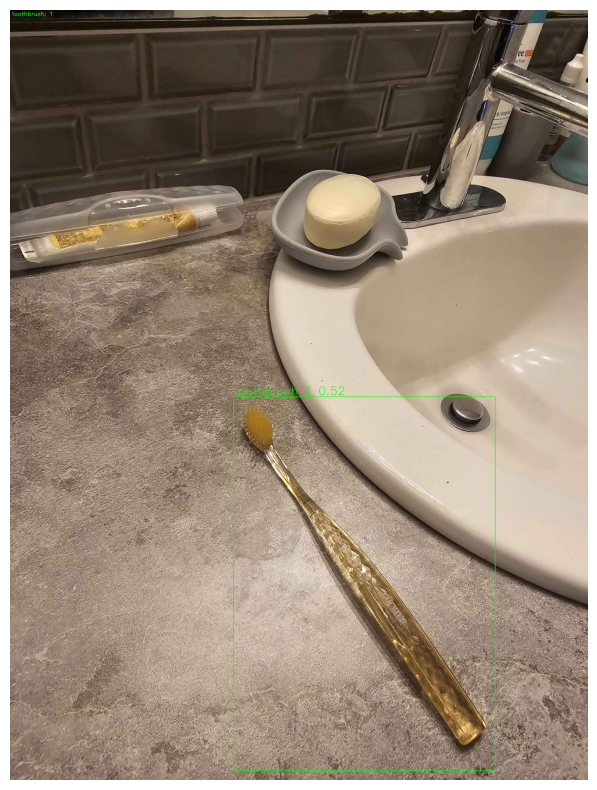


image 1/1 /content/scissorsmice.jpg: 640x480 2 mouses, 2 scissorss, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


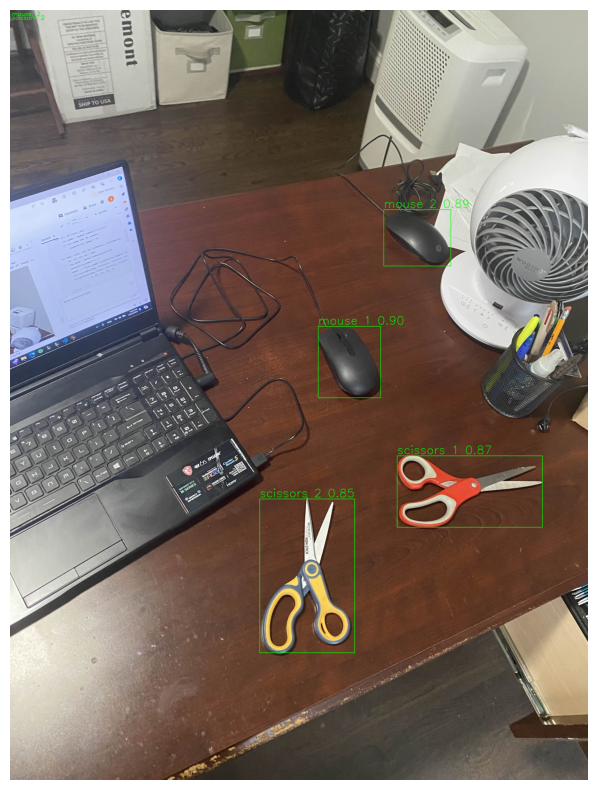


image 1/1 /content/scissorsopen.jpg: 640x480 1 mouse, 1 scissors, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


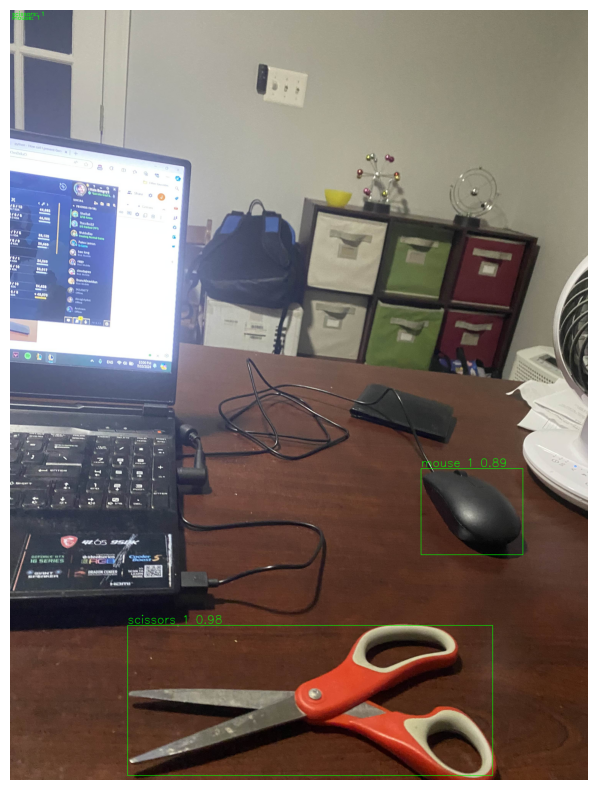

In [37]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Visualize
def plot_boxes(img, boxes, confidences, class_ids, model_names):
    counts = {}

    for box, conf, cls in zip(boxes, confidences, class_ids): # Iterate using zip
        x1, y1, x2, y2 = box
        cls_name = model_names[int(cls)]
        if cls_name in counts:
            counts[cls_name] += 1
        else:
            counts[cls_name] = 1

        label = f'{model.names[int(cls)]} {counts[cls_name]} {conf:.2f}'
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(img, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    2, (0, 255, 0), 2)

    y_offset = 30
    for cls_name, count in counts.items():
        cv2.putText(img, f'{cls_name}: {count}', (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2)
        y_offset += 20

    return img

# Path to the image
image_paths = ['/content/toothbrush.jpg', '/content/scissorsmice.jpg', '/content/scissorsopen.jpg']
for image_path in image_paths:
    image = Image.open(image_path)
    image = np.array(image)

    # Resulting bounding boxes predicted by model
    results = model(image_path)

    if results[0].boxes.xyxy is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()  #.cpu for CPU usage, remove otherwise
        confidences = results[0].boxes.conf.cpu().numpy()
        class_ids = results[0].boxes.cls.cpu().numpy()
    else:
        boxes = []
        confidences = []
        class_ids = []

    # Plot the image with bounding boxes
    img_with_boxes = plot_boxes(image.copy(), boxes, confidences, class_ids, model.names) # Pass
    # confidences and class IDs

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img_with_boxes)
    plt.axis('off')
    plt.show()